## Detecção de incêndio usando aprendizado de máquina e redes neurais 
#### (Fire Detection using Machine Learning and Neural Networks)

<p align="center">
  <img src="img/incendio.jpg" alt="Detecção de incêndio" width="600">
</p>


Ao longo desse projeto construiremos um modelo de rede neural para classificar imagens de cenas de incêndio e não incêndio, que podem ter aplicações práticas em sistemas de detecção e prevenção de incêndio.

In [1]:
import datetime as dt                   # Trabalhar com datas e tempos
import numpy as np                      # Operações numéricas e manipulação de array
import pandas as pd                     # Manipulação e análise de dados

import matplotlib.pyplot as plt             # Visualização de dados
import seaborn as sns                       # Visualização de dados
plt.style.use('fivethirtyeight')             
sns.set_style('whitegrid')                  

import os                  # Interagir com o sistema operacional
from keras.applications import xception       # Carregar modelos de aprendizado profundo pré-treinados e pré-processar imagens
from keras.preprocessing import image         ## 
from mpl_toolkits.axes_grid1 import ImageGrid      # Criar uma grade de imagens 
from sklearn.linear_model import LogisticRegression              # Para regressão logística, avaliação de modelo e otimização de hiperparâmetros
from sklearn.metrics import accuracy_score, confusion_matrix     ##
from sklearn.model_selection import train_test_split, RandomizedSearchCV                
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report     

import cv2                           # Biblioteca OpenCV para processamento de imagens
from scipy.stats import uniform      # Gerar variáveis aleatórias contínuas 

from tqdm import tqdm     # Exibir barra de progresso
from glob import glob     # Para encontrar caminhos de arquivos que correspondam a um padrão  

from keras.models import Model, Sequential       # Para criar modelos keras
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking   # Várias camadas keras para construir a arquitetura da rede neural
from keras.utils import to_categorical      # Para trabalhar com dados categóricos

from IPython.core.interactiveshell import InteractiveShell    # Configure o Shell interativo do IPython para exibir toda a saída de uma célula
InteractiveShell.ast_node_interactivity = "all"     # Este código configura o ambiente para um projeto de aprendizado de máquina, especialmente para tarefas de classificação de imagens.



 Essa parte é responsavel por configurar o diretório de cache para armazenar modelos keras pré-treinados, especificamente o modelo Xception, para uso posterior no projeto.


In [2]:
# A copiando os modelos pré-treinados para o diretório de cache.
cache_dir = os.path.expanduser(os.path.join('~','.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
Models_dir = os.path.join(cache_dir, 'Models')
if not os.path.exists(Models_dir):
    os.makedirs(Models_dir)

# Copiar os modelos Xception.
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/

# Show
!ls ~/.keras/models

'cp' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'ls' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [3]:
base_folder = 'fire_dataset/'                           # Se refere a raiz do conjunto de dados
data_folder = 'fire_dataset/'                           # Se refere a pasta de dados principal com imagens de incêndio e não incêndio
train_data_folder = 'fire_dataset/fire-images'          # Se refere a pasta que contém as imagens de incêndio
test_data_folder = 'fire_dataset/non_fire_images'       # Se refere a pasta que contém as imagens de não incêndio 

categories = ['fire_images','non_fire_images']       # Criando uma lista com imagens de incêndio e não incêndio
len_categories = len(categories)                 # Armazena o comprimento da lista de categorias (ou seja, o número de classes na tarefa de classificação)

Essa célula de código percorre as pastas de imagens de incêndio e não incêndio, conta o número de imagens em cada categoria e cria uma lista chamada train_data contendo informações sobre cada imagem.

In [4]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])
        

2it [00:02,  1.49s/it]


Essa célula de código percorre o dicionário image_count e imprie o número de imagens para cada categoria.

In [5]:
#Mostrar contagem de imagens
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


Essa célula de código cria um DataFrame do Pandas a partir da lista train_data, que contém informações sobre cada imagem e exibe a forma e as primeiras linhas do DataFrame.

In [6]:
# Criar um dataframe
df = pd.DataFrame(train_data, columns = ['file','id','label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.1.png,0,fire_images
1,fire_images/fire.10.png,0,fire_images
2,fire_images/fire.100.png,0,fire_images
3,fire_images/fire.101.png,0,fire_images
4,fire_images/fire.102.png,0,fire_images


Essa célula de código define quatro funções de processamento de imagem que executam mascaramento, segmentação, nitidez e carregamento de imagem.

In [7]:
# Função de mascaramento
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_hsv = np.array([0,0,255])    
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Função de segmentação de imagem
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask=mask)
    return output/255

# Afie a imagem
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0,0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# Função para obter uma imagem
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

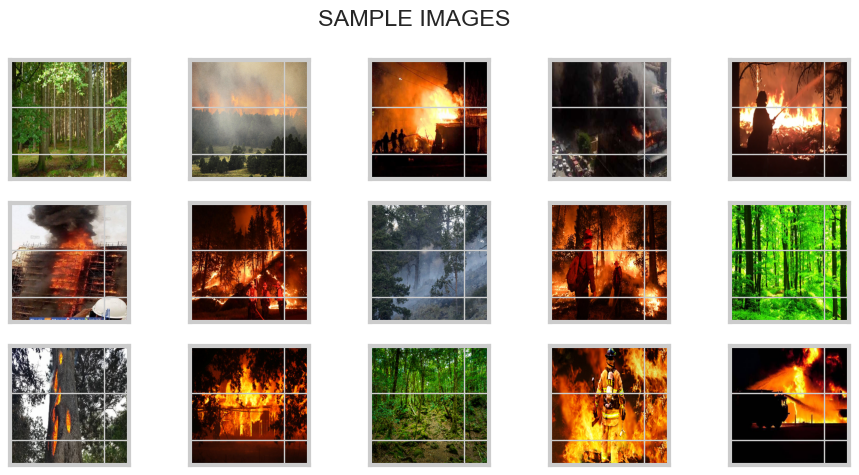

In [8]:
# Mostrar imagem de amostra
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();


Essa célula de códgo demonstra o pipilene de processamento de imagens em uma única imagem do processamento de imagens. Ele carrega a imagem, aplica a máscara, segmenta a imagem, torna-a mais nítida e exibe os resultados usando o Matplotlib.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


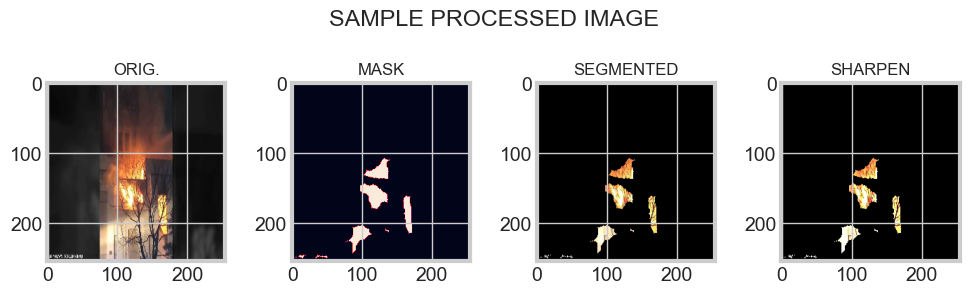

In [9]:
# Obter uma imagem
img = read_img(df['file'][102], (255,255))

# Máscara
image_mask = create_mask_for_plant(img)
# Segmentação
image_segmented = segment_image(img)
# Afiar a imagem(realçar as bordas da imagem)
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10,5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);


Aqui as imagens são processadas no conjunto de dados e preparadas para entrada em um modelo Xception. O processamento inclui redimensionamento, mascaramento, segmentação, nitidez e pré-processamento específico para o modelo Xception.

In [10]:
INPUT_SIZE=255

## Processar a entrada
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    # Ler a imagem
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    # Mascaramento e segmentação
    image_segmented = segment_image(img)
    # Aperfeiçoar
    image_segmented = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

999it [00:55, 17.90it/s]


Aqui imprimimos a forma e o tamanho da matriz X_train, que armazena as imagens pré-processadas para treinamento. 

In [11]:
print('Train image shape: ',X_train.shape)  # Informa quantas imagens estão na matriz e as dimensões de cada uma
print('Train Image Size:', X_train.size)  # Esse valor dá uma noção do consumo de memória da matriz



Train image shape:  (999, 255, 255, 3)
Train Image Size: 194879925


IMPORTANTE: Ao imprimir esses dois valores acima, você entende a estrutura e os requisitos de memória das imagens processadas armazenadas na matriz X_train.
 
Essas informções podem ser úteis para determinar a viabilidade de treinar um modelo em sua máquina ou para fazer ajustes no pipeline de pré-processamento, se necessário.



A célula abaixo divide as imagens pré-processadas e seus rótulos correspondentes em conjuntos de treinamento e de validação.

In [12]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size = 0.2, random_state = 101)

###### Legenda:
###### train_X: são as imagens pré-processadas para o conjunto de treinamento.
###### train_val: as imagens pré-processadas para o conjunto de validação.
###### y_train: os rótulos do conjunto de treinamento.
###### y_val: os rótulos do conjunto de validação.

Ao dividir seus o conjuntos de dados em conjuntos de treinamento e validação. Você pode treinar um modelo de aprendizado de máquina no conjunto de treinamento e avaliar seu desempenho no conjunto de validação. Isso permite estimar o desempenho do modelo com base em dados não visos e fazer ajustes na arquitetura ou nos hipeparâmetros do modelo conforme necessário para melhorar seu desempenho.


A célula abaixo imprime o número de imagens de incêndio e de imagens não relacionadas a incêndio no conjunto de dados de treinamento depois de dividir os dados em conjuntos de treinamento e validação. Ao imprimir as contagens de imagens de incêndio e não-incêndio no conjunto de dados de treinamento. Você pode obter insights sobre a distribuição de turmas do seu conjunto de dados. Essas informações podem ser úteis para entender se o conjunto de dados está balanceado e se quaisquer ajustes ou etapas de pré-processamento, como sobreamostragem ou subamostragem, são necessários para equilibrar as classes para melhorar o desempenho do modelo.

In [13]:
print('FIRE IMAGES ON TRAINING DATA:', y_train[y_train == 0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA:', y_train[y_train == 1].shape[0])

FIRE IMAGES ON TRAINING DATA: 610
NON-FIRE IMAGES ON TRAINING DATA: 189


Essa célula abaixo extrai recursos das imagens pré-processadas usando o modelo Xception como extrator de recursos.

In [14]:
# Obtendo o recurso
xception_bf = xception.Xception(weights = 'imagenet', include_top = False, pooling = 'avg')
bf_train_x = xception_bf.predict(train_x, batch_size = 32, verbose = 1)
bf_train_val = xception_bf.predict(train_val, batch_size = 32, verbose = 1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step


Esta célula abaixo imprime a forma e o tamanho das matrizes de recursos obtidas após usar o modelo Xception como extrator de recursos para os conjuntos de dados de treinamento e validação. Ao imprimir esses valores, você pode entender a estrutura e os requisitos de memória dos recursos extraídos para os conjuntos de treinamento e validação. Essas informações podem ser úteis para determinar a viabilidade de treinar um classificador em sua máquina ou para fazer ajustes no processo de extração de recursos, se necessário.

In [15]:
# Recurso e tamanho da forma de impressão
print('Train shape ', bf_train_x.shape)
print('Train_size: ', bf_train_x.size)

print('Validation shape ', bf_train_val.shape)
print('Validation size: ', bf_train_val.size)


Train shape  (799, 2048)
Train_size:  1636352
Validation shape  (200, 2048)
Validation size:  409600


Logo abaixo é criada uma rede neural feedforward simples usando a API Keras Sequential onde é compilada para treinamento.

In [16]:
# Deep learning model
model = Sequential()
model.add(Dense(units = 256, activation = 'relu', input_dim = bf_train_x.shape[1]))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

c:\Users\Fernandinho\Desktop\data-science\venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,057 (2.06 MB)

 Trainable params: 541,057 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

A célula abaixo treina o modelo de rede neural criado na etapa anterior nos recursos extraídos usando o método fit. bf_train_x: conjunto de recursos extraidos das imagens de treinamento usando o modelo Xception. Ele serve como entrada para o modelo de rede neural. y_train: esta é a matriz de rótulos correspondente às imagens de treinamento. Ele serve como base para o modelo de rede neural durante o treinamento. Épocas=100: o número de vezes que todo o conjunto de dados passará pela rede neural durante o treinamento. Uma época é uma iteração completa no conjunto de dados de treinamento. O modelo de treinamento treinará por 100 épocas. batch_size = 32: o número de amostras por atualização de gradiente durante o treinamento. O modelo será atualizado após o processamento de 32 amostras. Este é um hiperparâmetro que pode ser ajustado para equilibrar eficiência computacional e velocidade de convergência.

History: O médotod fit retorna um objeto History, que contém um registro de valores de perda de treinamento e valores de métricas em épocas sucessivas. Você pode usar essa informções para analisar o processo de treinamento, traçar curvas de aprendizado ou determinar o número ideal de períodos de treinamento.

In [17]:
# Train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs = 100, batch_size = 32);

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.7121 - loss: 0.5881
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7522 - loss: 0.5607
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7738 - loss: 0.5384
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7805 - loss: 0.5304 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7421 - loss: 0.5733
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7646 - loss: 0.5534
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7707 - loss: 0.5393
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7689 - loss: 0.5413
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7778 - loss: 0.5362
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7764 - loss: 0.5358
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7439 - loss: 0.5755
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accura

A célula abaixo é cria um subtrama 1x2 e traça a perda e a precisão do treino ao longo do processo de treinamento usando o objeto de histórico retornando pelo método fit. Depois de executar esse código, você verá uma visualização da perda de treinamento e da precisão de treinamento ao longo do tempo(épocas). Isso pode ajudar você a entender o quão bem o modelo está aprendendo com os dados, identificar possíveis problemas (como o sobreajuste ou subajuste) e determinar o número ideal de épocas para treinamento.

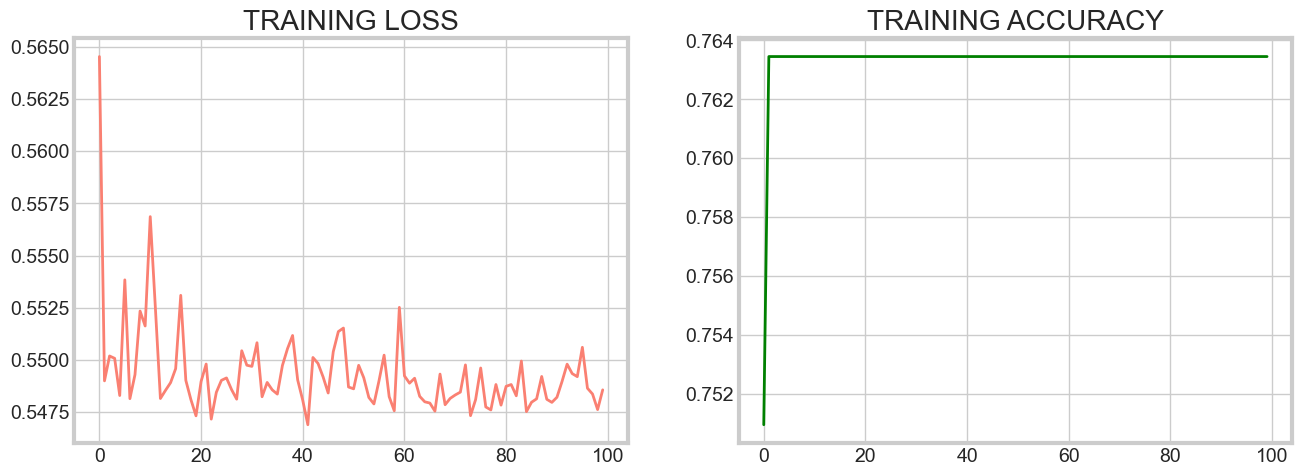

In [18]:
# Perda e precisão (loss and accuracy)
fig, ax = plt.subplots(1,2,figsize = (14,5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')

ax[0].plot(history.history['loss'], color = 'salmon', lw = 2);
ax[1].plot(history.history['accuracy'], color = 'green', lw = 2);